In [1]:
import pynumdiff
import matplotlib.pyplot as plt
import numpy as np
import scipy.integrate
scipy.stats
import copy

/home/caveman/BMD2/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/caveman/BMD2/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/caveman/BMD2/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/caveman/BMD2/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:526: Futu

In [76]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
import pandas

In [2]:
dt = 0.01
xyz, xyz_dxyzdt_truth, extras = pynumdiff.utils.simulate.rk4_lorenz_xyz(4, dt=dt, noise_parameters=[0, 0.0001])

In [77]:
def get_library(x, y, z, dt, integrations=0):
    
    base_library = [x, y, z, x**2, y**2, z**2, x*y, x*z, y*z, 
                    np.sin(x), np.sin(y), np.sin(z),
                    np.cos(x), np.cos(y), np.cos(z),
                    np.sin(2*x), np.sin(2*y), np.sin(2*z),
                    np.cos(2*x), np.cos(2*y), np.cos(2*z),
                    x**3, y**3, z**3, x**2*y, x**2*z, y**2*x, y**2*z, z**2*x, z**2*y,
                    x**5, y**5, z**5, x**4*y, x**4*z, y**4*x, y**4*z, z**4*x, z**4*y,
                    np.sin(4*x), np.sin(4*y), np.sin(4*z),
                    np.cos(4*x), np.cos(4*y), np.cos(4*z),
                    np.cos(4*x+0.5), np.cos(4*y+0.5), np.cos(4*z+0.5),
                    x**6, y**6, z**6, x**5*y, x**5*z, y**5*x, y**5*z, z**5*x, z**5*y,
                    np.sin(3*x), np.sin(3*y), np.sin(3*z),
                    np.cos(3*x), np.cos(3*y), np.cos(3*z),
                    np.sin(5*x), np.sin(5*y), np.sin(5*z),
                    np.cos(5*x), np.cos(5*y), np.cos(5*z),]
    
    return base_library

In [80]:
def integrate(x, dt):
    y = scipy.integrate.cumtrapz( x )*dt
    y = np.hstack((y[0]-x[0]*dt, y))
    return y

def integrate_library(library, dt):
    library = [integrate(l, dt) for l in library]
    library.append(np.ones_like(library[0]))
    return library

In [81]:
def get_coeff_correlations(phi, state, lib):
    rvals = []
    for i in range(phi.shape[1]):
        p = copy.copy(phi)
        p[0,i] = 0
        r = scipy.stats.linregress(np.ravel(p*lib), np.ravel(state.T))
        rvals.append (r.rvalue)
    return rvals

In [348]:
def integral_sindy(states, library, dt, eps=1e-1, pval=1e-2, num_iter=10):
    '''
    states  - list of 1d arrays of time-series data
    library - 
    
    
    dx/dt = phi*library
    
    this function solves the integral formulation 
    
    
    Returns
    -------
    
    phis - list of arrays, one for each state, an array of coefficients corresponding to the library
    
    '''
    integral_library = integrate_library(library, dt)
    
    int_lib = np.matrix(np.vstack(integral_library))
    
    
    phis_for_states = []
    idxs_for_states = []
    for N, state in enumerate(states):

        state = np.matrix(state)
        num_iter = 20

        threshold = eps*10**(-1*int(num_iter/2))
        idx = np.arange(0,int_lib.shape[0])
        lib_idx = np.ones(int_lib.shape[0]).astype(int)
        for i in range(num_iter):
            if threshold < eps:
                threshold *= 10
            phi0 = state*np.linalg.pinv(np.matrix(np.diag(lib_idx))*int_lib)
            idx = np.where(np.abs(np.array(phi0)[0,:])<threshold)[0]
            lib_idx[idx] = 0
            phi0[:, idx] = 0

        phi0 = np.ravel(phi0)
        phi0[-1] = 0 # throw out the intercept
        original_indices = np.arange(0, len(integral_library))
        idx = np.where(np.abs(phi0)>threshold)[0]

        select_integral_library = integral_library

        for i in range(2):
            select_integral_library = [select_integral_library[i] for i in idx]
            original_indices = [original_indices[i] for i in idx]
            df = pandas.DataFrame(np.vstack(select_integral_library).T, columns=['input_'+str(i) for i in range(len(select_integral_library))])
            df['state'] = np.ravel(state)

            inputs = ''.join([k+'+' for k in df.keys()[0:-1]])[0:-1]
            mod = ols('state ~ ' + inputs,
                            data=df).fit()
            
            idx = np.where( (mod.pvalues[1:]<pval) )[0]

        select_integral_library = [select_integral_library[i] for i in idx]
        original_indices = [original_indices[i] for i in idx]
        phi0 = mod.params[1:]

        phis_for_states.append(phi0)
        idxs_for_states.append(original_indices)
    
    return idxs_for_states, phis_for_states, mod.rsquared_adj

In [355]:
dt = 0.01
xyz, xyz_dxyzdt_truth, extras = pynumdiff.utils.simulate.rk4_lorenz_xyz(4, dt=dt, noise_parameters=[0, 0.5],
                                                                       normalize=False)
states = [np.ravel(xyz[s,:]) for s in range(xyz.shape[0])]
library = get_library(states[0], states[1], states[2], dt)
idxs_for_states, phis_for_states, r_squared = integral_sindy(states, library, dt, 
                                                             eps=1e-2, pval=.00001)
print(r_squared)

0.9985801842910986


In [356]:
phis_for_states

[input_0   -10.165296
 input_1    10.094793
 dtype: float64, input_0    45.782941
 input_1    -1.201987
 input_2    -1.011818
 dtype: float64, input_0   -2.658416
 input_1    1.002893
 dtype: float64]

In [357]:
idxs_for_states

[[0, 1], [0, 1, 7], [2, 6]]

In [358]:
integral_library = integrate_library(library, dt)

In [359]:
P = np.matrix(phis_for_states[0])
L = np.matrix(np.array(integral_library)[idxs_for_states[0]])

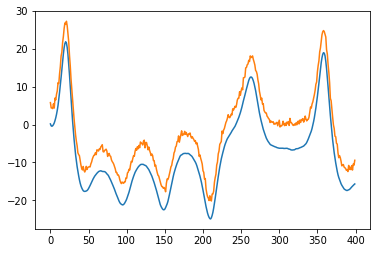

In [360]:
plt.plot((P*L).T)
plt.plot(states[0])

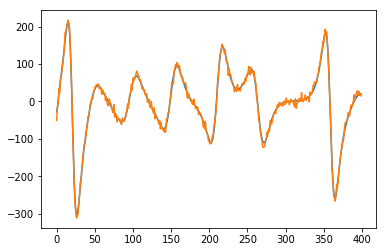

In [361]:
plt.plot(xyz_dxyzdt_truth[3])

P = np.matrix(phis_for_states[0])
L = np.matrix(np.array(library)[idxs_for_states[0]])

plt.plot(np.ravel(P*L))